# Simulating trajectories

## Circular eddies configuration

In this example we will consider an idealised configuration (inspired by [this one](https://docs.oceanparcels.org/en/latest/examples/parcels_tutorial.html#Running-particles-in-an-idealised-field) from Parcels documentation) where the velocity field presents two eddies displaced over time.

We consider a spatial domain spanning from 29° to 31° latitude and -1° to 1° longitude, and a time period of two days.

In [1]:
import jax.numpy as jnp

In [2]:
ny = nx = 100
nt = 48

lat = jnp.linspace(29, 31, ny)
lon = jnp.linspace(-1, 1, nx)

dt = jnp.asarray(1*60*60)  # 1 hour in seconds
ts = jnp.linspace(0, dt * (nt - 1), nt)

Below we defined our fields, considering circular and geostrophic eddies.

In [3]:
from sealagrangiax.utils.unit import degrees_to_meters

In [4]:
dy, dx = degrees_to_meters(jnp.asarray([lat[1] - lat[0], lon[1] - lon[0]]), lat.mean())

# SSH field parameters
eta0 = .4
sig = 0.1
eta_fn = lambda _dx, _dy: eta0 * jnp.exp(-(_dx / (sig * nx))**2 - (_dy / (sig * ny))**2)
xi, yi = jnp.meshgrid(jnp.arange(lon.size), jnp.arange(lat.size), indexing="ij")

# eddies displacement parameters
eddy_speed = .05
dxi = eddy_speed * dt / dx
dyi = eddy_speed * dt / dy

# SSH field
eta = jnp.zeros((nt, ny, nx))
for t in range(nt):
    # eddy 1
    x1 = 0.5 * lon.size - (9 + dxi * t)
    y1 = 0.5 * lat.size - (9 + dyi * t)
    eta = eta.at[t, :, :].add(eta_fn((x1 - xi), (y1 - yi)))

    # eddy 2
    x2 = 0.5 * lon.size + (9 + dxi * t)
    y2 = 0.5 * lat.size + (9 + dyi * t)
    eta = eta.at[t, :, :].add(-eta_fn((x2 - xi), (y2 - yi)))

# geostrophic velocities
coriolis_factor = 2 * 7.292115e-5 * jnp.sin(jnp.radians(lat.mean()))
g = 9.81

u = jnp.zeros_like(eta)
u = u.at[:, :-1, :].set(jnp.diff(eta[:, :, :], axis=1) / dy / coriolis_factor * g)
u = u.at[:, -1, :].set(u[:, -2, :])

v = jnp.zeros_like(eta)
v = v.at[:, :, :-1].set(-jnp.diff(eta[:, :, :], axis=-1) / dx / coriolis_factor * g)
v = v.at[:, :, -1].set(v[:, :, -2])

In [5]:
import matplotlib.pyplot as plt

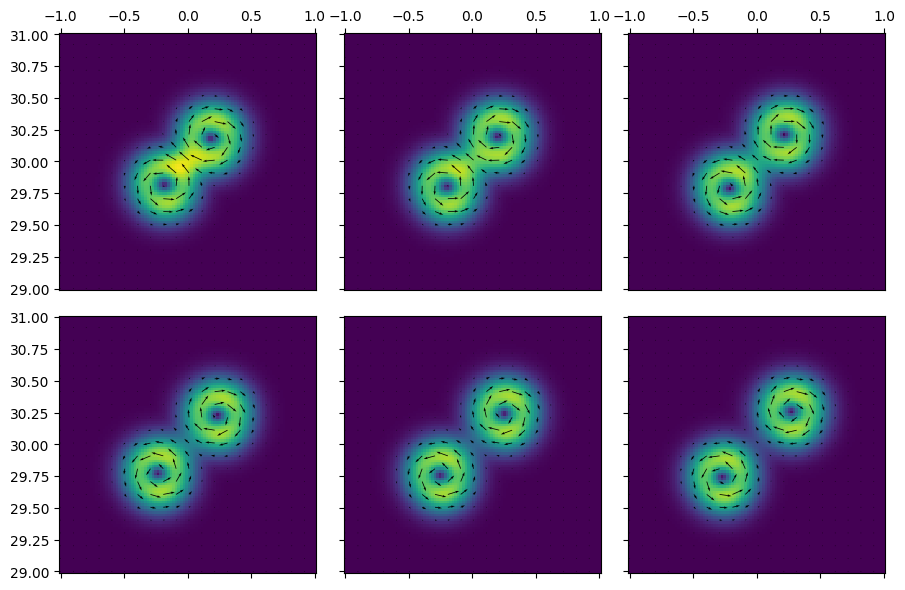

In [6]:
fig, axes = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(9, 6))
axes = axes.flatten()

for ax_i, uv_i in zip(range(axes.size), jnp.linspace(0, nt - 1, axes.size).astype(int)):
    ax = axes[ax_i]
    
    im = ax.pcolormesh(
        lon, lat,
        jnp.sqrt(u[uv_i]**2 + v[uv_i]**2), 
        vmax=2.75, vmin=0,
        cmap="viridis"
    )
    ax.quiver(
        lon[::5], lat[::5], 
        u[uv_i][::5, ::5], v[uv_i][::5, ::5],
        scale=50
    )

    ax.set_aspect("equal")

    if ax_i < 3:
        ax.tick_params(bottom=False, labelbottom=False, top=True, labeltop=True)
    else:
        ax.tick_params(bottom=True, labelbottom=False, top=False, labeltop=False)

fig.tight_layout()

## Deterministic simulation

Let's start with the simpliest use-case: advecting a single particle inside our given velocity field.

In order to interpolate this velocity field during the simulation of the trajectory we define a `sealagrangiax.Dataset` (a `xarray.Dataset`-likish object compatible with JAX jit-compilation).

In [7]:
from sealagrangiax.grid import Dataset

In [8]:
jax_ds = Dataset.from_arrays(
    variables={"u": u, "v": v},  # the fields
    time=ts, latitude=lat, longitude=lon,  # the coordinates
    convert_uv_to_dps=True  # wether the u and v fields should be converted from m/s to °/s
)

The initial position of our particle is [30, 0] lat/lon.
We use `sealagrangiax.Location` structure to represent positions.

In [9]:
from sealagrangiax.trajectory import Location

In [10]:
x0 = Location([30, 0])

Finally we will advect this particle using the `sealagrangiax.IdentitySSC` simulator.

In [11]:
from sealagrangiax.simulator import IdentitySSC

In [12]:
dt0 = jnp.asarray(1*60)  # integration timestep: 1 minute in seconds

In [13]:
ssc_sim = IdentitySSC()
traj = ssc_sim(jax_ds, x0, ts, dt0=dt0)

The simulator outputs a `sealagrangiax.Trajectory` object.
We can plot it using its method `plot`.

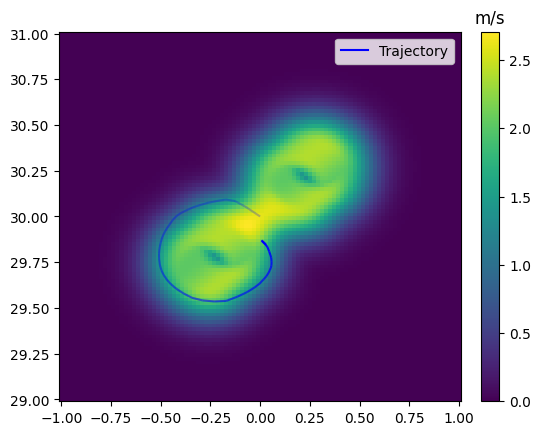

In [14]:
# plot the field
fig, ax = plt.subplots()

im = ax.pcolormesh(
    lon, lat,
    jnp.sqrt((u**2 + v**2)).max(axis=0), 
    cmap="viridis", vmin=0
)
clb = fig.colorbar(im, ax=ax, orientation="vertical", pad=0.04)

clb.ax.set_title("m/s")

# add the trajectory
ax = traj.plot(ax, label="Trajectory", color="blue")
ax.legend()

plt.show()

## Stochastic simulation

Often we do not know exactly the velocity field and we rely on ensemble simulation to sample probable trajectory realisation.

In this example, we generate an ensemble of 10 trajectories by sampling solutions from a Stochastic Differential Equation with a Smagorinsky diffusion.

In [15]:
from sealagrangiax.simulator import SmagorinskyDiffusion

In [16]:
n_samples = jnp.asarray(10)

In [24]:
smag_sim = SmagorinskyDiffusion.from_param(cs=1e-1)
traj_ens = smag_sim(jax_ds, x0, ts, dt0=dt0, n_samples=n_samples)

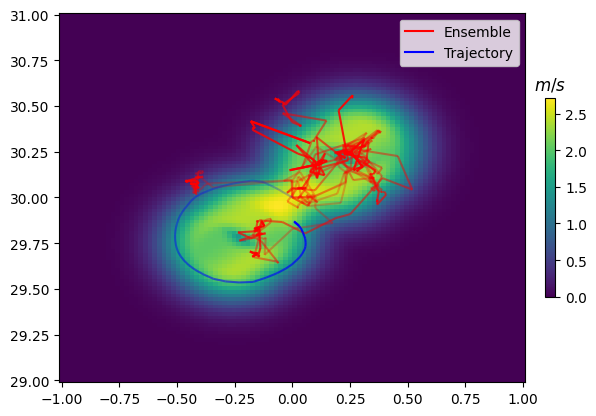

In [25]:
# plot the field
fig, ax = plt.subplots()

im = ax.pcolormesh(
    lon, lat,
    jnp.sqrt((u**2 + v**2)).max(axis=0), 
    cmap="viridis", vmin=0
)
clb = fig.colorbar(im, ax=ax, orientation="vertical", fraction=0.02, pad=0.04)

clb.ax.set_title("$m/s$")

# add the ensemble
ax = traj_ens.plot(ax, label="Ensemble", color="red")

# add the trajectory on top
ax = traj.plot(ax, label="Trajectory", color="blue")
ax.legend()

plt.show()

In [20]:
import equinox as eqx

from sealagrangiax.simulator import LinearSSC

In [21]:
@eqx.filter_value_and_grad
def loss(_sim):
    _traj_biased = _sim(jax_ds, x0, ts[1:-1], dt0=jnp.asarray(30*60))
    return traj.separation_distance(_traj_biased).sum().value

In [22]:
val, grad = loss(linear_ssc_sim)

NameError: name 'linear_ssc_sim' is not defined

In [13]:
val

Array(758945.8, dtype=float32)

In [14]:
grad.ode_vf.intercept

Array([2.2777627e+10, 7.5961370e+09], dtype=float32)